### Introduction
Text analytics can be very fascinating. In this multi-part mini project series, we explore several common text analytics techniques. The dataset is acquired from bookshare.org free ('Once and Future King'). Let's start by loading the data.

In [1]:
# import libraries
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textstat
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from wordcloud import WordCloud
from PIL import Image
import imageio

In [2]:
# settings
plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.rc('figure', titlesize=16, titleweight='bold')
plt.rc('axes', titlesize=16, titleweight='bold', titlepad=10, 
       labelsize=14, labelweight='bold')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

In [3]:
# use glob to get list of filenames
txts = glob.glob('./The_Once_Future_King/*.txt')
txts

['./The_Once_Future_King\\The_Once_Future_King00001.txt',
 './The_Once_Future_King\\The_Once___Future_King00002.txt',
 './The_Once_Future_King\\The_Once___Future_King00003.txt']

In [4]:
# function to read the files into a list
def extract(txts):
    full_txts = []
    for file in txts:
        with open(file, mode='r', encoding='ISO-8859-1') as f:
            content = f.read()
            full_txts.append(content)
    return full_txts

# function to check extracted content
def check(data):
    print(f'length: {len(data)}')
    print(f'first_text: {data[0][:30]}')
    print(f'end of check\n')
    
# function to clean book title
def title_cleaner(txt):
    title_list = [ele.split('\\')[1].split('.')[0].replace('__','') for ele in txt]
    return title_list

# function for barplots (text metrics)
def barplot(title, ylabel, xlabel, series, dataframe):
    plt.bar(x=np.arange(1,len(dataframe)+1), height=series)
    plt.xticks(np.arange(1,len(dataframe)+1))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [5]:
full_list = extract(txts)
check(full_list) # there should be three
# clean and organise the book titles into a list
name = title_cleaner(txts)
print(name)

length: 3
first_text: The Once & Future King
T. H. W
end of check

['The_Once_Future_King00001', 'The_Once_Future_King00002', 'The_Once_Future_King00003']


In [6]:
# Organise data into dataframe
d = {'title': name, 'content': full_list}
df = pd.DataFrame(data=d)
df

,title,content
0,The_Once_Future_King00001,The Once & Future King\nT. H. White\nFreely Di...
1,The_Once_Future_King00002,\nCHAPTER XII\nThe battle of Bedegraine was fo...
2,The_Once_Future_King00003,\nCHAPTER XI\nGuenever sat in the Queen's cham...


### Cleaning the data
We'll need to clean up the data. We can look through the content for each book briefly to get a sensing of the cleaning to be implemented, systematically.

In [7]:
book1 = full_list[0]
book1[:500]

'The Once & Future King\nT. H. White\nFreely Distributable Material\nThis notice describes the copyright ownership, if any, and any legal restrictions on the use of this Bookshare digital material which govern your lawful use of it. Bookshare believes in good faith that this digital material is freely distributable, and is either in the Public Domain or available under a license that allows free distribution (such as a Creative Commons license).\nTitle: The Once & Future King\nAuthor: T. H. White\nCopy'

In [8]:
# replace newline in text
cleaned_content = [ele.replace("\n", " ") for ele in df['content']]
df['content'] = cleaned_content

In book 1, there are some commentary that needs to be removed. Reviewing the content, we could do this by splitting the text by 'CHAPTER' (luckily for us, we can exploit this pattern later on) and taking the rest of the text from thereon. Alternatively, we could find the index of the first occurrence of the word 'CHAPTER' and slice the list. Let's opt for the latter.

In [9]:
# remove commentary for book 1
df['content'][0] = df['content'][0][df['content'][0].index('CHAPTER'):]
# save the dataframe
df.to_csv('cleaned_df.csv')

### Metrics
Let's look at metrics such as word length, sentence length, readability etc.

In [10]:
# character count
df['char_cnt'] = [len(ele) for ele in df['content']]
# word count
df['word_cnt'] = [len(word_tokenize(ele)) for ele in df['content']]
# sentence count
df['sent_cnt'] = [len(sent_tokenize(ele)) for ele in df['content']]

In [11]:
df

,title,content,char_cnt,word_cnt,sent_cnt
0,The_Once_Future_King00001,"CHAPTER I On Mondays, Wednesdays and Fridays i...",591764,132758,7624
1,The_Once_Future_King00002,CHAPTER XII The battle of Bedegraine was foug...,633676,140196,8434
2,The_Once_Future_King00003,CHAPTER XI Guenever sat in the Queen's chambe...,71332,16355,1129


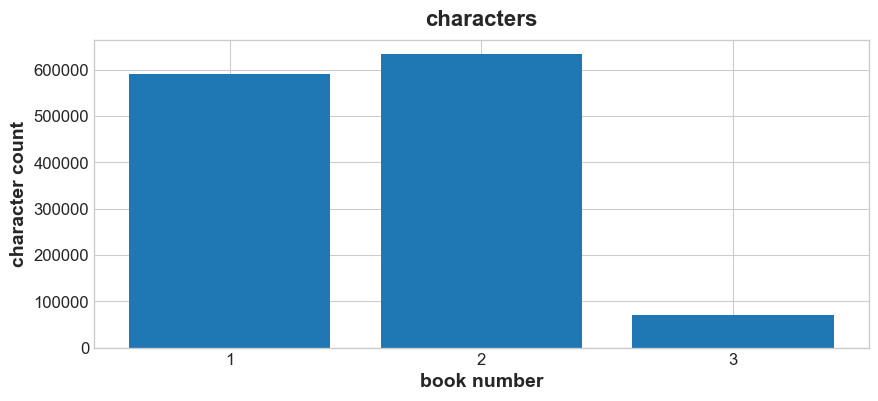

In [12]:
# characters (letters)
plt.figure(figsize=(10,4))
barplot('characters', 'character count', 'book number', df['char_cnt'], df)

Interesting that the last book, book 3 is the shortest, while book 2 is the longest of the three books.

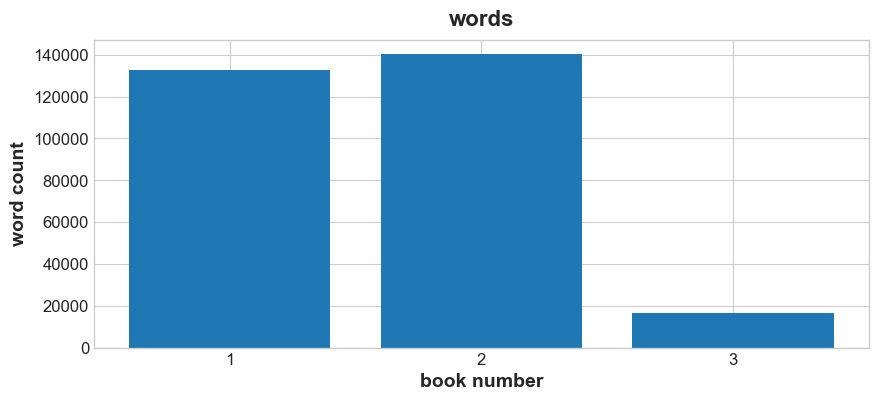

In [13]:
# word count
plt.figure(figsize=(10,4))
barplot('words', 'word count', 'book number', df['word_cnt'], df)

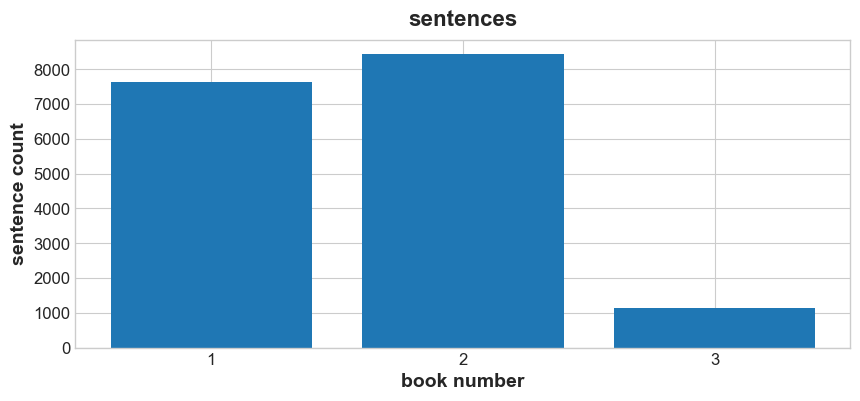

In [14]:
# sentence count
plt.figure(figsize=(10,4))
barplot('sentences', 'sentence count', 'book number', df['sent_cnt'], df)

Fairly consistent plots, the three plots appear similar.

In [15]:
df['word_per_sentence'] = df['word_cnt'] / df['sent_cnt']

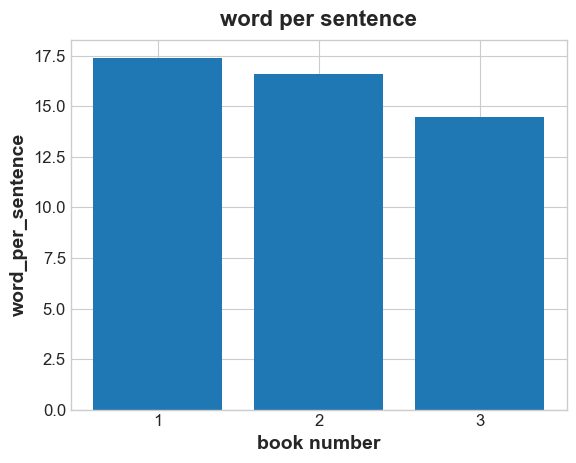

In [16]:
barplot('word per sentence', 'word_per_sentence', 'book number', df['word_per_sentence'], df)

The words per sentence gradually decrease from 17 to less than 15 words per sentence across the books.

### Dale-Chall score
The Dale-Chall readibility score is based on a list of 3000 words that fourth-graders commonly understand. Words not in that list are considered difficult. How would the score be like for these books?

|Score|	Understood by|
|---|---|
|4.9 or lower	| average 4th-grade student or lower |
|5.0–5.9	| average 5th or 6th-grade student |
|6.0–6.9	| average 7th or 8th-grade student |
|7.0–7.9	| average 9th or 10th-grade student |
|8.0–8.9	| average 11th or 12th-grade student |
|9.0–9.9	| average 13th to 15th-grade (college) student |

In [17]:
# derive the Dale-Chall score for
df['Dale-Chall score'] = [textstat.dale_chall_readability_score(ele)
    for ele in df['content']]

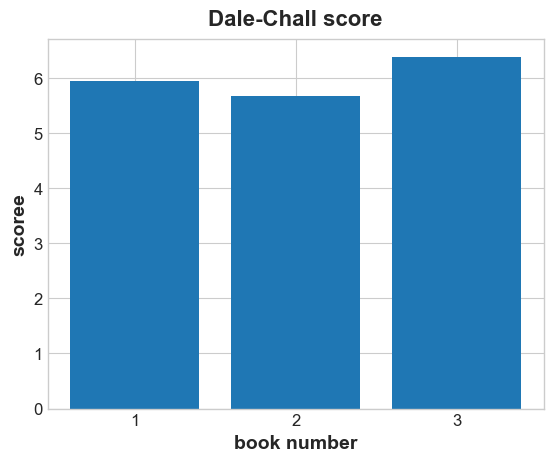

In [18]:
barplot('Dale-Chall score', 'scoree', 'book number', df['Dale-Chall score'], df)

The score is generally around 6; target audience would be around 12-14 years of age and above.

### Text cleaning, analysis and WordCloud
For more analysis, let's do some more cleaning such as removing punctuations and stopwords, before moving on to word frequency and word cloud.

In [19]:
# dictionary to manage each book text
BOOKS = {}
for i in range(1,len(df)+1):
    BOOKS[i] = df['content'][i-1]

In [20]:
# prepare the set of stopwords from nltk
# update and reuse this as necessary
stop_words = set(stopwords.words('english'))

In [21]:
# function to clean text of each book
def text_cleaner(booktxt, stop_words):
    # split into words
    tokens_list = word_tokenize(booktxt)
    # lowercase
    tokens_list = [token.lower() for token in tokens_list]
    # remove all tokens not alphabetic
    alpha_words = [word for word in tokens_list if word.isalpha()]
    # filter stop words
    words = [w for w in alpha_words if not w in stop_words]
    return words

In [22]:
# function to generate word frequency dataframe for each book
def word_F(words):
    cnt = Counter()
    for word in words:
        cnt[word] += 1
    # 30 most common words as data frame
    word_freq = pd.DataFrame(cnt.most_common(30),
                             columns=['words', 'count'])
    return word_freq

In [23]:
# combine the two functions above
# function to loop through all three books, get word freq as dataframes
def df_wrdfreq(df, stop_words):
    df_list_ = []
    for i in range(1,len(df)+1):
        cleaned_words = text_cleaner(BOOKS[i], stop_words)
        df_ = word_F(cleaned_words)
        df_list_.append(df_)
    return df_list_

In [24]:
# Function to plot horizontal bar graph
def bar_h(df_, i):
    df_.sort_values(by='count').plot.barh(x='words',
                          y='count',
                          color="green")
    plt.title(f"Common Words Found, book {i+1}")
    plt.tight_layout()
    plt.show()

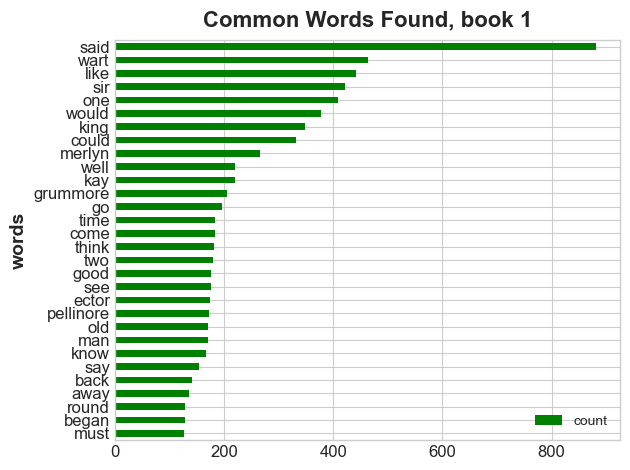

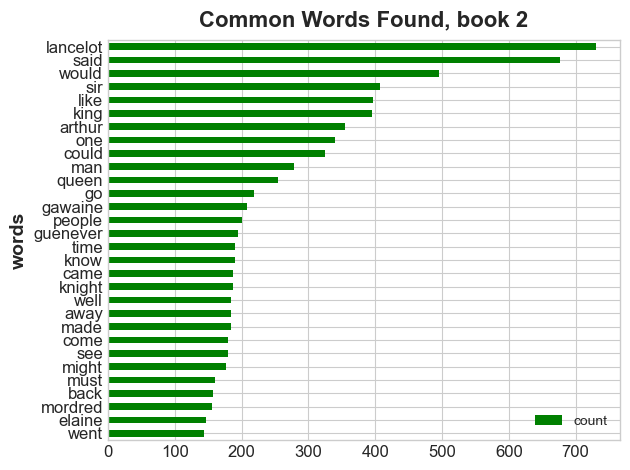

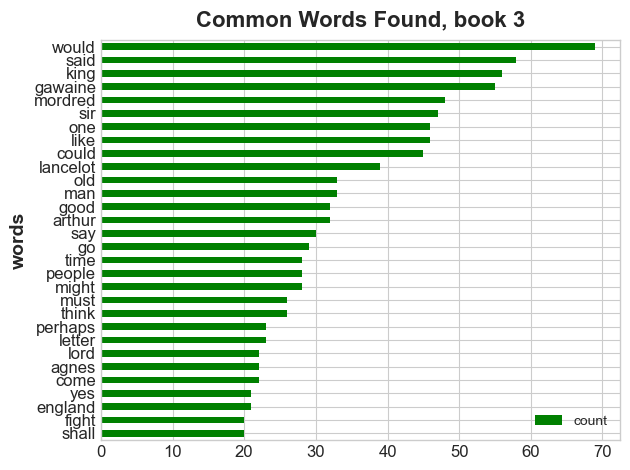

In [25]:
df_list = df_wrdfreq(df, stop_words)
for i in range(len(df_list)):
    bar_h(df_list[i], i)

Looks like there's some common words that could be removed to improve analysis. Let's remove them.

In [26]:
words_remove = {'said', 'like', 'one', 'would', 'could', 'chapter', 'might', 'must', 
                'back', 'must', 'perhaps', 'yes', 'shall'}

In [27]:
# update the stop words...
stop_words.update(words_remove)

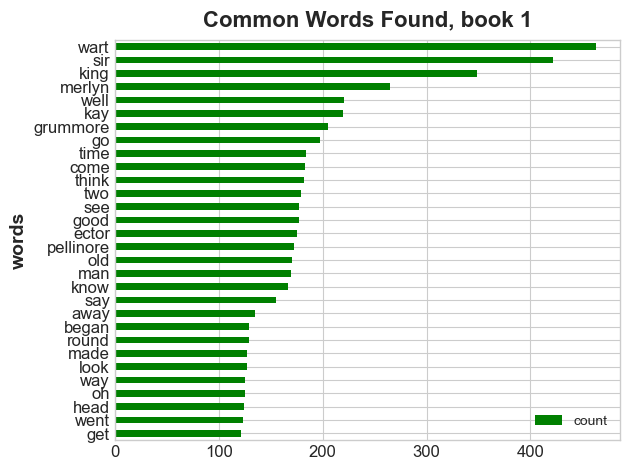

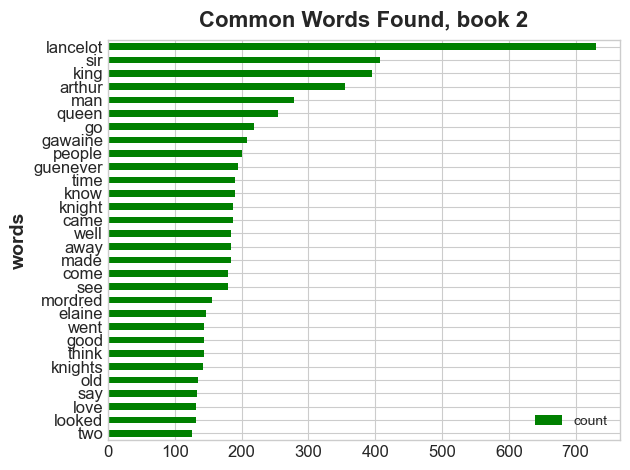

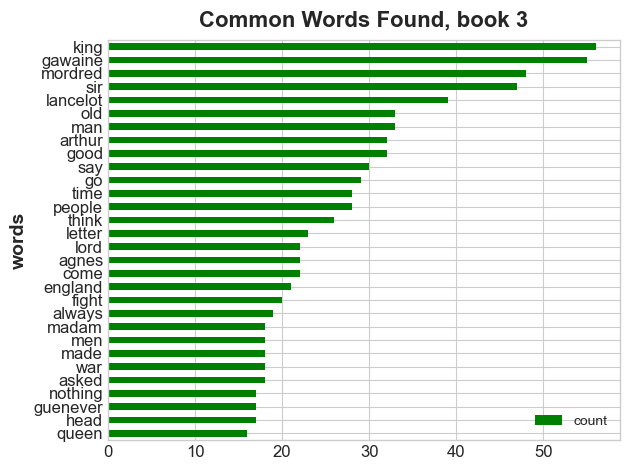

In [28]:
# plot the word frequency plots again
df_list = df_wrdfreq(df, stop_words)
for i in range(len(df_list)):
    bar_h(df_list[i], i)

### Planning for Word Cloud
We can use Word Cloud to visualise text-based insights, together with the use of n-grams. N-grams are continuous sequences of words/ tokens in a document. 
In the following section, we generate two word cloud types for the three books - one based on uni-gram, the other based on n-grams (n ranges from two to five). In addition, we throw in a mask to generate the wordcloud in the shape we want. I used an arbitrary free image from the net.

In [29]:
mask = np.array(Image.open( "king_chess.png"))

In [30]:
# Unigram word cloud function
def unigramWrdCld(txt, i):
    txt_lwr = txt.lower()
    wrdcld = WordCloud(max_words=50, stopwords=stop_words, 
                       background_color='white',
                       max_font_size=60,
                       width=400, height=300,
                       colormap=plt.cm.plasma,
                       mask=mask, contour_width=2, contour_color='indigo').generate(txt_lwr)
    plt.figure( figsize=(8,4))
    plt.axis('off')
    plt.title(f'WordCloud - Unigram Book{i}')
    plt.imshow(wrdcld, interpolation='bilinear')
    plt.savefig(f'unigramwordcloud_{i}.png')
    plt.show()

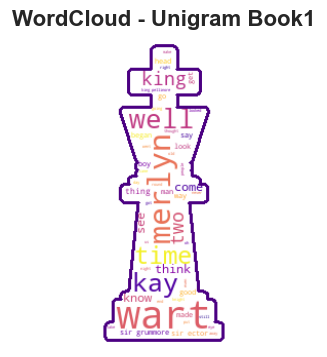

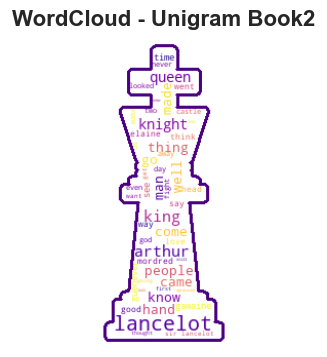

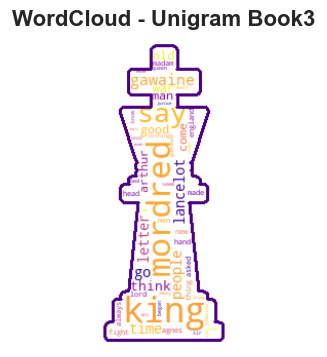

In [31]:
# generate the first set of wordcloud (unigrams)
for i in range(1, len(df)+1):
    unigramWrdCld(BOOKS[i], i)

In [32]:
# Build n-gram models 
def N_grams(text, min_=2, max_=5):
    # split into words
    tokens_list = word_tokenize(text)
    # lowercase
    tokens_list = [token.lower() for token in tokens_list]
    # remove all tokens not alphabetic
    alpha_words = [word for word in tokens_list if word.isalpha()]
    # filter stop words
    words = [w for w in alpha_words if not w in stop_words]
    #print("Sentence after removing stopwords:",words)
    s = []
    for n in range(min_, max_):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

In [33]:
gramsBooks = {}
freq_gramsBooks = {}
for i in range(1, len(df)+1):
    gramsBooks[i] = N_grams(BOOKS[i])
    freq_gramsBooks[i] = FreqDist(gramsBooks[i])

In [34]:
# N-gram word cloud function
def n_gramWrdCld(freq_grams, i):
    wrdcld = WordCloud(max_words=20, stopwords=stop_words, 
                       background_color='white',
                       max_font_size=60,
                       width=400, height=300,
                       colormap=plt.cm.plasma,
                       mask=mask, contour_width=3, contour_color='indigo'
                      ).generate_from_frequencies(freq_grams)
    plt.figure( figsize=(8,4))
    plt.axis('off')
    plt.title(f'WordCloud - N-grams Book{i}')
    plt.imshow(wrdcld, interpolation='bilinear')
    plt.savefig(f'ngramwordcloud_{i}.png')
    plt.show()

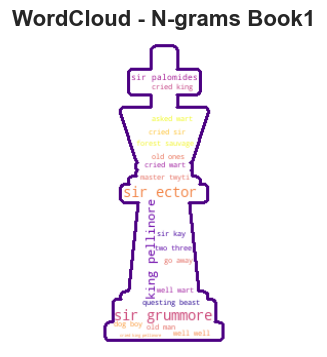

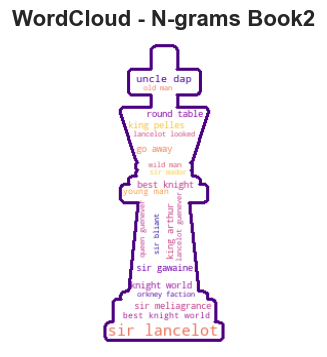

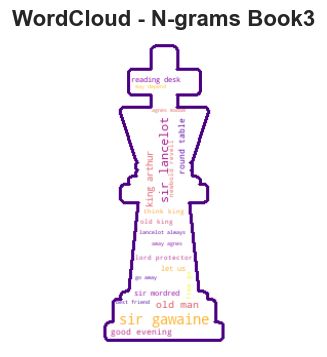

In [35]:
# generate the second set of wordcloud (Ngrams)
for i in range(1, len(df)+1):
    n_gramWrdCld(freq_gramsBooks[i], i)

In [36]:
# visualise as gif
with imageio.get_writer('Unigrams.gif', mode='I', fps=0.75) as writer:
    for filename in ['unigramwordcloud_1.png',
                     'unigramwordcloud_2.png',
                     'unigramwordcloud_3.png']:
        image = imageio.imread(filename)
        writer.append_data(image)
        
with imageio.get_writer('Ngrams.gif', mode='I', fps=0.75) as writer:
    for filename in ['ngramwordcloud_1.png',
                     'ngramwordcloud_2.png',
                     'ngramwordcloud_3.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

Personally, much of the time was spent exploring textstat and there's much to explore in terms of the metrics generated from textstat.
Wordcloud is interesting and the additional challenge was trying to refactor the initial wordcloud function fot n-grams. 
We'll look into sentiment analysis for part two. That's it for now!